In [1]:
import dataset
import models

import importlib
importlib.reload(dataset)
importlib.reload(models)

import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl

import tensorflow as tf
import tensorflow_addons as tfa 

import datetime

/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [163]:
# LOAD IMAGE AND LABELS
img_folder = '/Users/erebor/Downloads/out_img'
labels_file = 'labels.txt'
names_file = 'names.txt'
MIN_NUM_ARTWORK = 25

data_kwargs = {'MIN_NUM_ARTWORK':MIN_NUM_ARTWORK,'img_folder':img_folder,'labels_file':labels_file,'names_file':names_file}
images, labels_onehot, labels, names, = dataset.load_data(**data_kwargs)

 [███████████████████████████████████████-] 112038/112039 

Dataset loaded!

images shape:	  (73886, 56, 56, 3)
labels shape:	  (73886,)
labels (one-hot): (73886, 627)
names shape:	  (73886, 1)

              # of unique artists: 627
Min # of artworks for all artists: 25
      Min # of artworks specified: 25


In [165]:
labels_safe = labels

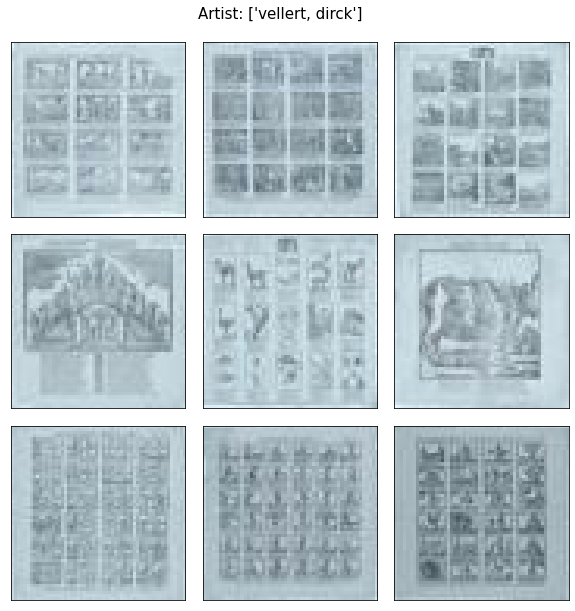

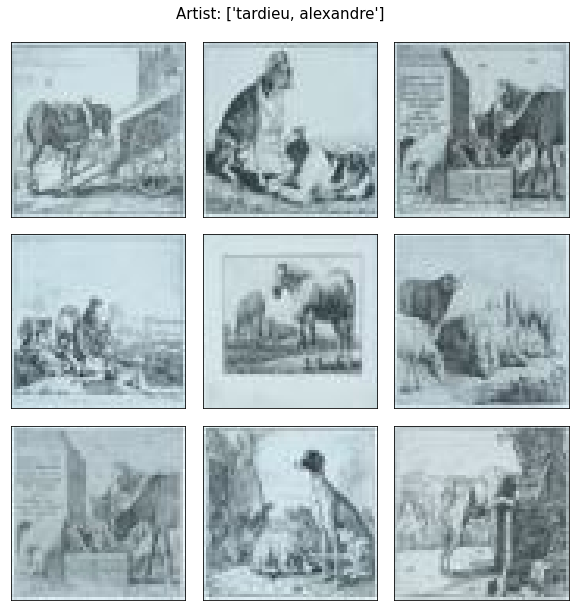

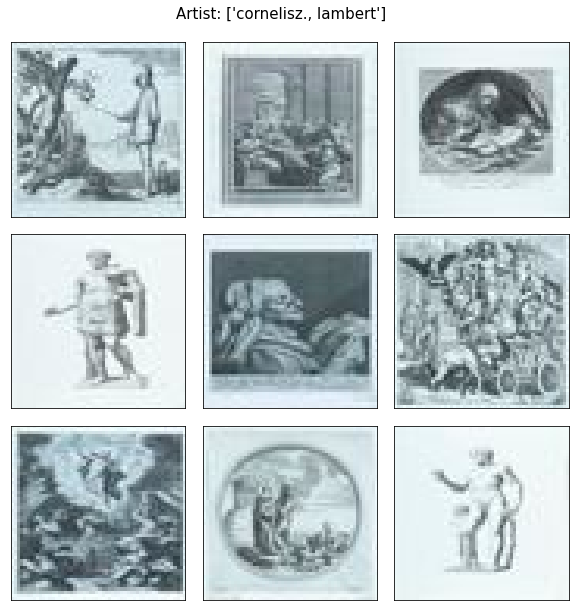

In [166]:
for i in range(3):
    artist_label = np.random.choice(np.unique(labels),1)[0]
    dataset.plot_artwork(images,labels,names,artist_label,n=3)

In [167]:
# GENERATE IMAGE VECTORS
vector_length = 50
input_shape = images.shape[1:]
encoder_kwargs = {'input_shape':input_shape,'vector_length':vector_length,'activation':'sigmoid'}
encoder = models.load_encoder(**encoder_kwargs)
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                25650     
Total params: 20,050,034
Trainable params: 25,650
Non-trainable params: 20,024,384
_________________________________________________________________


In [184]:
# Create encode image to generate vectors for all data examples 
vectors = encoder.predict(images,verbose=1)
np.savetxt(X=vectors,fname='vectors.csv',delimiter=',')

2309/2309 [==============================] - 724s 314ms/step


In [186]:
aggregate_vectors, artistnames, artistnums = dataset.get_aggregrate_vectors(vectors,labels,names)

 [███████████████████████████████████████-] 626/627 
Done! Aggregrate vectors for 627 artist(s) generated.

aggregrate_vectors shape: (627, 50)
saved to: aggregrate_vectors.csv


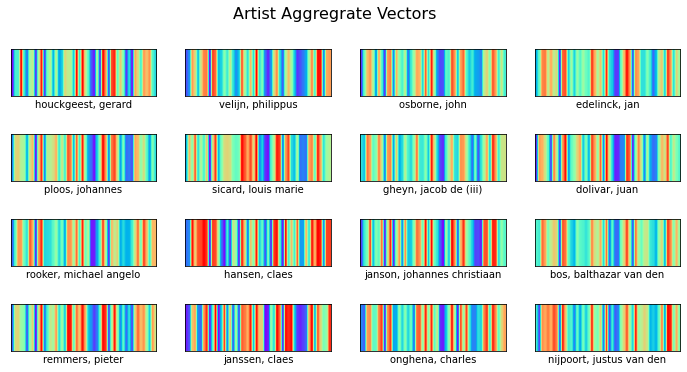

In [188]:
dataset.plot_aggregate_vectors(aggregate_vectors,artistnames,n=4)

In [185]:
importlib.reload(dataset)
importlib.reload(models)

<module 'models' from '/Users/erebor/repos/ML_Rijksmuseum/models.py'>

In [198]:
vector_kwargs = {'vectors':vectors,
                 'names':names,
                 'labels':labels,
                 'train_val_split':0.8,
                 'dev_split': 0.}

train_pairs, train_labels, dev_pairs, dev_labels, val_pairs, val_labels = \
    dataset.load_vectors(**vector_kwargs)

/Users/erebor/repos/ML_Rijksmuseum/dataset.py:170: RuntimeWarning: overflow encountered in multiply
  new_aggregate_vector = (aggregate_vector - (query_vector * (1/artcount))) * (artcount/(artcount-1))


   train set pair shape: (118217, 50, 2)
  train set label shape: (118217, 1)
     dev set pair shape: (0, 50, 2)
    dev set label shape: (0, 1)
     val set pair shape: (29555, 50, 2)
    val set label shape: (29555, 1)


In [199]:

# Create the model
tf.keras.backend.clear_session()
MLP = tf.keras.models.Sequential()

activation = tf.keras.layers.ReLU()
activation = tf.keras.layers.LeakyReLU(alpha=0.01)

MLP.add(tf.keras.layers.InputLayer((vector_length,2)))
MLP.add(tf.keras.layers.Flatten())
MLP.add(tf.keras.layers.Dense(1000, activation=activation, bias_regularizer='l1'))
MLP.add(tf.keras.layers.Dropout(rate=0.2))
MLP.add(tf.keras.layers.Dense(100, activation=activation))
MLP.add(tf.keras.layers.Dropout(rate=0.1))
MLP.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [200]:
# loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,
                                          label_smoothing=0.0,name='binary_crossentropy')

# metrics
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
roc = tf.keras.metrics.AUC()
metrics = ["acc",f1,roc]

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile it all
MLP.compile(loss=loss,
            optimizer=optimizer,
            metrics=metrics)

In [201]:
MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              101000    
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 201,201
Trainable params: 201,201
Non-trainable params: 0
__________________________________________________

In [202]:
epochs = 10
fit_kwargs = {'x':train_pairs,
             'y':train_labels,
             'validation_data':(val_pairs,val_labels),
             'epochs':epochs,
             'verbose':1}
history = MLP.fit(**fit_kwargs)

Epoch 1/10
3695/3695 [==============================] - 6s 2ms/step - loss: 0.6586 - acc: 0.5867 - f1_score: 0.6002 - auc: 0.6294 - val_loss: 0.5747 - val_acc: 0.6973 - val_f1_score: 0.7091 - val_auc: 0.7717
Epoch 2/10
3695/3695 [==============================] - 6s 1ms/step - loss: 0.5812 - acc: 0.6921 - f1_score: 0.7006 - auc: 0.7605 - val_loss: 0.5618 - val_acc: 0.7044 - val_f1_score: 0.7160 - val_auc: 0.7804
Epoch 3/10
3695/3695 [==============================] - 6s 2ms/step - loss: 0.5651 - acc: 0.7028 - f1_score: 0.7106 - auc: 0.7771 - val_loss: 0.5582 - val_acc: 0.7057 - val_f1_score: 0.7352 - val_auc: 0.7898
Epoch 4/10
3695/3695 [==============================] - 6s 2ms/step - loss: 0.5604 - acc: 0.7063 - f1_score: 0.7121 - auc: 0.7814 - val_loss: 0.5555 - val_acc: 0.7100 - val_f1_score: 0.7370 - val_auc: 0.7933
Epoch 5/10
3695/3695 [==============================] - 6s 2ms/step - loss: 0.5497 - acc: 0.7171 - f1_score: 0.7219 - auc: 0.7926 - val_loss: 0.5436 - val_acc: 0.7167 -

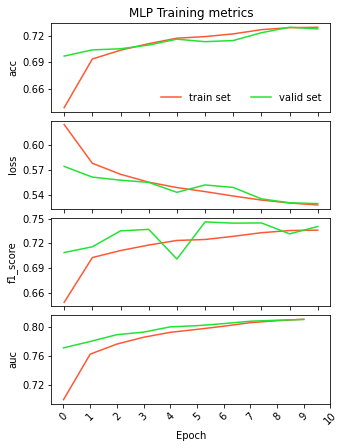

In [203]:

box = dict(facecolor='white', pad=0, alpha=0.)
metrics = ['acc','loss','f1_score','auc']
fig, ax = plt.subplots(ncols=1,nrows=len(metrics),figsize=(5,len(metrics)+3),sharex=True,sharey=False)
for idx, stat in zip(range(len(metrics)),metrics):
    ax[idx].plot(history.history[stat],color='#FF5733')
    ax[idx].plot(history.history['val_' + stat],color='#21E332')
    ax[idx].set_ylabel(stat, bbox=box)

    ax[idx].yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))

plt.xlabel('Epoch')
plt.subplots_adjust(hspace=0.1)
plt.xticks(np.arange(0,epochs+0.1,1),rotation=45)
ax[0].legend(['train set', 'valid set'],ncol=2,frameon=False)
ax[0].set_title('MLP Training metrics')
plt.savefig('figs/training.png',dpi=200)
plt.show()

In [ ]:
reconstructed_MLP = tf.keras.models.load_model('models/MLP.h5')
allgood = np.testing.assert_allclose(MLP.predict(train_pairs), reconstructed_MLP.predict(train_pairs))

In [231]:
def get_aggregrate_vectors(vectors,labels,names):
    # Create aggregate vectors
    # Count how many pieces each artist has
    total_bc = np.bincount(labels) # get count of artists
    artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
    artistnames = names[np.unique(labels)] # get the name for each unique artist

    aggregate_vectors = []
    artistnums = []
    for i in range(len(artcounts)):

        artistnum = np.unique(labels)[i] #Gets the number that represents this artist from labels
        artistname = artistnames[i]
        artcount = artcounts[i] #Gets number of art pieces by this artist

        artistnums.append(artistnum)
        pos_idx = np.where(labels == artistnum)
        artist_vector = np.mean(vectors[pos_idx],axis=0)

        aggregate_vectors.append(artist_vector)

    aggregate_vectors = np.array(aggregate_vectors)
    
    print('\nDone! Aggregrate vectors for {} artist(s) generated.'.format(aggregate_vectors.shape[0]))
    print('\naggregrate_vectors shape:',aggregate_vectors.shape)
    fname = 'aggregrate_vectors.csv'
    print('saved to:',fname)
    np.savetxt(X=vectors,fname=fname,delimiter=',')
    aggregate_names = artistnames
    aggregate_counts = artcounts
    aggregate_index = np.unique(labels)
    return aggregate_vectors, aggregate_index, aggregate_names, aggregate_counts

In [234]:
aggregate_vectors, aggregate_labels, aggregate_names, aggregate_counts = get_aggregrate_vectors(vectors,labels,names)


Done! Aggregrate vectors for 627 artist(s) generated.

aggregrate_vectors shape: (627, 50)
saved to: aggregrate_vectors.csv


In [264]:
for query_vector,query_index,query_name in zip(vectors,labels,names):
    
    pairs =[]
    for agg_vec,agg_index,agg_name in zip(aggregate_vectors,aggregate_labels,aggregate_names):
        pair = np.vstack((query_vector,agg_vec)).T
        pairs.append(pair)
    pairs = np.array(pairs)
    
    pred_labels = MLP.predict(pairs)
    sort_idx = np.argsort(pred_labels,axis=0).flatten()[::-1]

    y_true = query_index
    y_pred = aggregate_labels[sort_idx]
    y_pred_names = aggregate_names[sort_idx]
    acc = tf.keras.metrics.top_k_categorical_accuracy(y_true=query_index,
                                                      y_pred=y_pred,
                                                      k=10)

InvalidArgumentError: Expected dimension in the range [0, 0), but got -1 [Op:ArgMax]

In [ ]:
print(acc)

In [ ]:
pred_labels = MLP.predict_classes(train_pairs)
print(pred_labels)

## start evaluation here

In [ ]:
# ROC curve

In [ ]:
# confusion matrix